<a href="https://colab.research.google.com/github/polislizarralde/PythonMathematicalModeling/blob/main/docs/PlagueProject/databaseScania.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 3


In [2]:
# Python 3.11.2
from funct_process_data import *  # Import all functions from funct_process_data.py
%matplotlib inline


We have three different data sources. 

1. The data collected by Bodil corresponds to the plague period.
2. The data provided by Lennart Palm which contains the population size for each parish in 1699 and 1718 based on a combination of tax records and estimations of population totals for Scania.
3. The information from the TABVERK database includes the population size for parishes in the posterior years of the plague.
4. The geographical information (polygons) for some parishes. This information doesn't correspond to the plague period.

Our goal is to create a unique database for our project: Plague spread across Scania, Sweden, from 1710 to 1715.

1. We start working with Bodil's information which we store in two databases: One database corresponds to the parishes affected by the plague, the region where parishes are located in Scania, the beginning and end of the outbreaks, and the number of victims. The second database corresponds to all the parishes in Scania during the plague period, the district, and the region they belonged to.

The goal is to merge these two databases. First we set the working directory for private and public files.

In [3]:
# For public files paths
data_folder = "data"
appendix6_path = os.path.join(data_folder, "Appendix6Bodil.csv")

# For private files paths
data_private_folder = "data/private"
allParishes_path = os.path.join(data_private_folder, "allParishesScania.xlsx")

Reading the different data sources (.xlsx, and .csv files)

In [4]:
# Bodil's data Appendix 6 plague parishes
plagueParishesScania = pd.read_csv(appendix6_path, sep=",", encoding="utf-8")
# All parishes in Scania during the plague period
allParishesScania = pd.read_excel(allParishes_path)
# All parishes from the Southeast, Middle and Southwest region of Scania with population data from Lennart Palm file
southeastScania = pd.read_excel(allParishes_path, sheet_name="southeast")

Transforming the lowercase to uppercase and checking the type

In [5]:
allParishesScania = allParishesScania.apply(
    lambda x: x.astype(str).str.upper())
plagueParishesScania = plagueParishesScania.apply(
    lambda x: x.astype(str).str.upper())
southeastScania = southeastScania.apply(
    lambda x: x.astype(str).str.upper())
type(plagueParishesScania)
type(allParishesScania)

pandas.core.frame.DataFrame

Visualizing the DataFrames and calculating the length of each one.

In [6]:
print(len(allParishesScania))
plagueParishesScania.head(3)

397


,BeginPlaguePeriod,EndPlaguePeriod,ParishName,VictimsNumber,Region
0,NOV 1710,APR 1711,NÄSUM,671,NORTHEAST
1,FEB 1712,UNDEFINED,NÄSUM,?,NORTHEAST
2,NOV 1710,AUG 1711,IVÖ,123,NORTHEAST


In [7]:
print(len(plagueParishesScania))
allParishesScania.head(3)

174


,Region,District(Härad),ParishName
0,SOUTHEAST,ALBO,ANDRARUM
1,SOUTHEAST,ALBO,BRÖSARP
2,SOUTHEAST,ALBO,ELJARÖD


Merging the two datasets (allParishesScania and plagueParishesScania)

In [8]:
parishesScania = pd.merge(
    allParishesScania, plagueParishesScania, how='left', on=['ParishName', 'Region'])

Checking that the new data frame keep all the outbreaks for parish

In [9]:
parishesScania.loc[parishesScania['ParishName'] == 'NÄSUM']


,Region,District(Härad),ParishName,BeginPlaguePeriod,EndPlaguePeriod,VictimsNumber
394,NORTHEAST,VILLANDS,NÄSUM,NOV 1710,APR 1711,671
395,NORTHEAST,VILLANDS,NÄSUM,FEB 1712,UNDEFINED,?


Extracting the parishes' names from the data frame

In [10]:
parishesScania_names = get_Names(
    parishesScania, 'ParishName').unique().tolist()
len(parishesScania_names)


396

The length of 'parishesScania_names' is less than the number of rows in the data frame 'allparishesScania'. This means, there is a repeated name: 'LÖDDEKÖPINGE'. We have to check the information for this parish:

In [11]:
parishesScania.loc[parishesScania['ParishName'] == 'LÖDDEKÖPINGE']


,Region,District(Härad),ParishName,BeginPlaguePeriod,EndPlaguePeriod,VictimsNumber
86,SOUTHWEST,HARJAGER,LÖDDEKÖPINGE,AUG 1712,DEC 1712,?
160,SOUTHWEST,TORNA,LÖDDEKÖPINGE,AUG 1712,DEC 1712,?


Only the parish LÖDDEKÖPINGE at HARJAGER was affected by the plague according to the file 'Bilaga 6 d - sydväst.doc' provided by Bodil. So we need to fix the information in the other row (160).

In [12]:
parishesScania.at[201, 'BeginPlaguePeriod'] = np.NaN
parishesScania.at[201, 'EndPlaguePeriod'] = np.NaN
parishesScania.at[201, 'VictimsNumber'] = np.NaN


Checking the data:

In [13]:
parishesScania.loc[parishesScania['ParishName'] == 'LÖDDEKÖPINGE']


,Region,District(Härad),ParishName,BeginPlaguePeriod,EndPlaguePeriod,VictimsNumber
86,SOUTHWEST,HARJAGER,LÖDDEKÖPINGE,AUG 1712,DEC 1712,?
160,SOUTHWEST,TORNA,LÖDDEKÖPINGE,AUG 1712,DEC 1712,?


Filtering the data frame by region and then get the names of the parishes:

In [14]:
southeastParishes = parishesByregion(parishesScania, 'SOUTHEAST')

In [15]:
southeastParishes_names = get_Names(southeastParishes, 'ParishName')
# Check parishes per region by name
southeastParishes.loc[southeastParishes['ParishName'] == 'RÖRUM']
len(southeastParishes_names)

62

2. Here, we used the population size estimations provided by Lennart Palm. Merging the two datasets (southeastScania and southeastParishes)

In [16]:
southeastParishesPop = pd.merge(
    southeastScania, southeastParishes, how='left', on=['ParishName', 'Region', 'District(Härad)'])

In [17]:
southeastParishesPop.head(3)

,Region,District(Härad),ParishName,BEF1699,BEF1718,AV_BEF,ChurchBook,OtherSources,BeginPlaguePeriod,EndPlaguePeriod,VictimsNumber
0,SOUTHEAST,ALBO,ANDRARUM,1100,1241,1170.5,2,5,NaN,NaN,NaN
1,SOUTHEAST,ALBO,BRÖSARP,480,541,510.5,2,5,NaN,NaN,NaN
2,SOUTHEAST,ALBO,ELJARÖD,320,361,340.5,3,4,JAN 1713,UNDEFINED,3


3. The geographical information for Scania is already projected on the plane, i.e. the measures are in meters not in longitude and latitude. To process the shape file, we proceed as with the census file. First, we set the directory and chose the columns to work with.

In [18]:
# Get the current working directory
data_folder = "MapScaniaSweden"
parishScania_path = os.path.join(data_folder, "Parishes1720_1890.shp")
SkaneMap_path = os.path.join(data_folder, "Skane1720_1890.shp")

SkaneMap = gpd.read_file(SkaneMap_path)
parishScaniaMap = gpd.read_file(parishScania_path)
selected_columns = ['G_NAME', 'GET_END_YE', 'geometry']
SkaneMap = SkaneMap[selected_columns]
parishScaniaMap = parishScaniaMap[selected_columns]


Now, we remove white spaces and patterns. Then, we filter the shape file considering the column "GET_END_YE" of the polygon.

In [19]:
parishScaniaMap = replace_strings_and_regex(parishScaniaMap, 'G_NAME', [' FÖRSAMLING', ' L LÄN', ' S LÄN', ' M LÄN', ' HELIGA TREFALDIGHETS', ' LANDSFÖRSAMLING', ' STADS', ' LANDS', ' SKÅNES'
                                                                        ])
parishScaniaMap = process_dataframe(parishScaniaMap, 'G_NAME', 'GET_END_YE')
len(parishScaniaMap)

412

Plotting the map only with the polygons obtained after clean the data

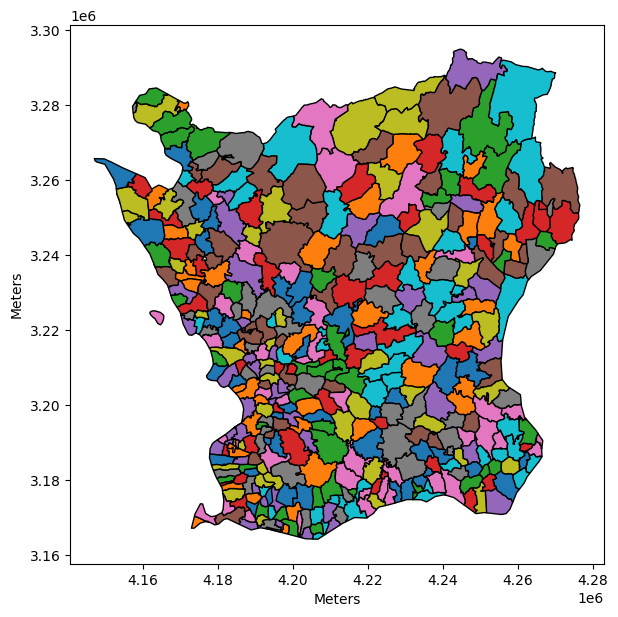

In [20]:
fig, ax = plt.subplots(figsize=(10, 7))
parishScaniaMap.plot(ax=ax, column="G_NAME", edgecolor='black', legend=False)
plt.xlabel('Meters')
plt.ylabel('Meters')
plt.show()

Working only with Southeast Scania: southeastParishesPop and parishScaniaMap

In [21]:
df1 = southeastParishesPop
df2 = parishScaniaMap

df_matches = fuzzy_match(
    df1,
    df2,
    'ParishName',
    'G_NAME',
    threshold=80,
    limit=1
)

df_output = df1.merge(
    df_matches,
    how='left',
    left_index=True,
    right_on='df_left_id'
).merge(
    df2,
    how='left',
    left_on='df_right_id',
    right_index=True,
    suffixes=['_df1', '_df2']
)

# For some reason the first merge operation wrecks the dataframe's index. Recreated from the value we have in the matches lookup table
df_output.set_index('df_left_id', inplace=True)

# df_output = df_output[['col_a_df1', 'col_b_df1', 'col_b_df2']]      # Drop columns used in the matching
df_output.index.name = 'id'

In [22]:
southeastParishMap = df_output[[
    'Region', 'District(Härad)', 'ParishName', 'G_NAME', 'BEF1699', 'BEF1718', 'AV_BEF', 'ChurchBook', 'OtherSources', 'BeginPlaguePeriod', 'EndPlaguePeriod', 'VictimsNumber', 'geometry']]
# Get the index for Skörup for fixing the geographical data
print(southeastParishMap.loc[southeastParishMap['ParishName'] == 'RÖRUM'])
print(southeastParishMap.loc[southeastParishMap['ParishName'] == 'SKÖRUP'])


       Region District(Härad) ParishName        G_NAME BEF1699 BEF1718 AV_BEF  \
id                                                                              
5   SOUTHEAST            ALBO      RÖRUM  SÖDRA RÖRUMS     393     444  418.5   

   ChurchBook OtherSources BeginPlaguePeriod EndPlaguePeriod VictimsNumber  \
id                                                                           
5           3            5               NaN             NaN           NaN   

                                             geometry  
id                                                     
5   POLYGON ((4219693.709 3227632.070, 4219625.094...  
       Region District(Härad) ParishName   G_NAME BEF1699 BEF1718 AV_BEF  \
id                                                                         
58  SOUTHEAST         LJUNITS     SKÖRUP  SKURUPS     242     273  257.5   

   ChurchBook OtherSources BeginPlaguePeriod EndPlaguePeriod VictimsNumber  \
id                                            

We need to modify manually the geographical information assigned to Skörup and Rörum for Sjörups and Rörums information,respectively.

In [23]:
# Get the geometry from the map
parishScaniaMap.loc[parishScaniaMap['G_NAME']
                    == 'SJÖRUPS', 'geometry'].values[0]
parishScaniaMap.loc[parishScaniaMap['G_NAME']
                    == 'RÖRUMS', 'geometry'].values[0]

# Get the name from the map
parishScaniaMap.loc[parishScaniaMap['G_NAME'] == 'SJÖRUPS', 'G_NAME'].values[0]
parishScaniaMap.loc[parishScaniaMap['G_NAME'] == 'RÖRUMS', 'G_NAME'].values[0]


'RÖRUMS'

In [24]:
southeastParishMap.at[5, 'G_NAME'] = parishScaniaMap.loc[parishScaniaMap['G_NAME']
                                                         == 'RÖRUMS', 'G_NAME'].values[0]
southeastParishMap.at[5, 'geometry'] = parishScaniaMap.loc[parishScaniaMap['G_NAME']
                                                           == 'RÖRUMS', 'geometry'].values[0]
southeastParishMap.at[58, 'G_NAME'] = parishScaniaMap.loc[parishScaniaMap['G_NAME']
                                                          == 'SJÖRUPS', 'G_NAME'].values[0]
southeastParishMap.at[58, 'geometry'] = parishScaniaMap.loc[parishScaniaMap['G_NAME']
                                                            == 'SJÖRUPS', 'geometry'].values[0]


In [25]:
type(southeastParishMap)

pandas.core.frame.DataFrame

In [26]:
southeastScaniaMap = gpd.GeoDataFrame(southeastParishMap, geometry='geometry')
# Add 1 if the parish was affected by the plague, 0 otherwise
classByPlague(southeastScaniaMap)

In [27]:
southeastScaniaMap.to_csv('southeastScania.csv', index=False)


In [28]:
southeastScaniaMap = get_area(southeastScaniaMap)
southeastScaniaMap = get_centroid(southeastScaniaMap)
from shapely.geometry import Point, mapping
southeastScaniaMap['centroid'] = southeastScaniaMap['centroid'].apply(mapping)

Plotting the southeast parishes

Before to plot the map of parishes, for a given Geodataframe, we assign 'red' to the parishes affected by the plague and blue for the others. This information is added as a column with heading 'color'.

In [29]:
colorByColumn(southeastScaniaMap, 'BeginPlaguePeriod')
southeastMap : folium.folium.Map = SkaneMap.explore(
    column="G_NAME",
    style_kwds=dict(color="black"),  # use black for borders
    tooltip=False,
    zoom_control=False,
    legend=False,
    #scheme="naturalbreaks",  # use mapclassify's natural breaks scheme
    legend_kwds=dict(colorbar=False),  # do not use colorbar
    name="Scania",  # name of the layer in the map
)

southeastScaniaMap.explore(
    m = southeastMap,  # pass the map object
    column="color",  # use "name" column to assign colors
    cmap=['blue','red'],  # color map to use
    legend=False,  # show legend
    style_kwds=dict(color="black"),  # use black for borders
    marker_kwds=dict(radius=5, fill=True),  # make marker radius 10px with fill
    # show "name" column in the tooltip
    tooltip=["G_NAME", "BEF1699", "BeginPlaguePeriod", "EndPlaguePeriod", "VictimsNumber"],
    tooltip_kwds=dict(labels=True),  # show column label in the tooltip
    name="Southeast Scania",  # name of the layer in the map,
    zoom_control=False,
)

folium.TileLayer("Stamen Toner", show=False).add_to(
    southeastMap
)  # use folium to add alternative tiles
folium.LayerControl().add_to(southeastMap)  # use folium to add layer control

southeastMap  # show map

In [30]:
type(southeastParishMap)

pandas.core.frame.DataFrame

In [31]:
# Assuming you have a GeoDataFrame named 'gdf'
def calculate_quotient(gdf, col1, col2):
    gdf[col1] = pd.to_numeric(gdf[col1], errors='coerce')
    gdf[col2] = pd.to_numeric(gdf[col2], errors='coerce')
    
    # Calculate the death rate per 1000 inhabitants
    gdf['quotient'] = (gdf[col1] / gdf[col2])*1000
    pass

calculate_quotient(southeastScaniaMap, 'VictimsNumber', 'BEF1699')

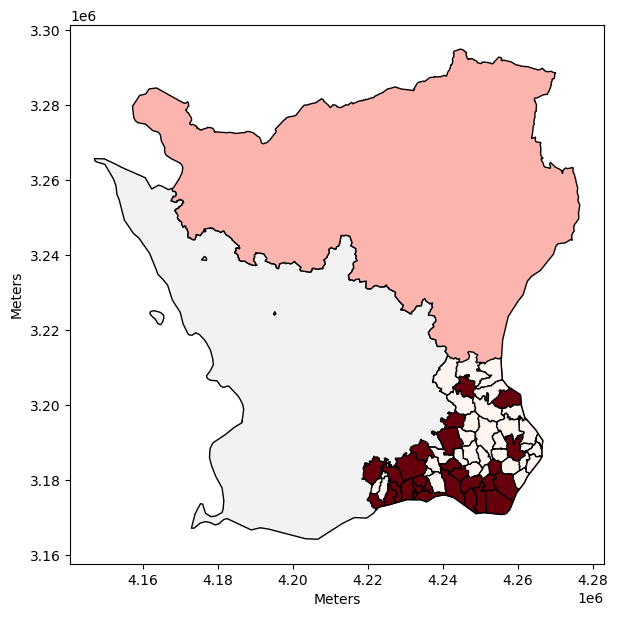

In [32]:
fig, ax = plt.subplots(figsize=(10, 7))
SkaneMap.plot(ax=ax, column="G_NAME", edgecolor='black',
              legend=False, cmap='Pastel1')
southeastScaniaMap.plot(ax=ax, column="color", cmap='Reds',
                        edgecolor='black', legend=False)
plt.xlabel('Meters')
plt.ylabel('Meters')
plt.show()


4. We will process the census file to get the population size by parish. This file corresponds to all of Sweden, so we process it to keep only the information for Scania for the closest year to the plague outbreaks. We start setting the directory and reading the census file:

In [33]:
# Set the working directory for private files
data_private_folder = "data/private"
census_path = os.path.join(data_private_folder, 'FILE01_FALD.csv')
censusSweden = pd.read_csv(census_path, sep=';')
censusSweden.shape


(102360, 50)

Checking the memory usage (this is not necessary)

In [34]:
# censusSweden.info(memory_usage='deep')


Checking the names of all columns in the data

In [35]:
columns = censusSweden.columns

Calling the data only with specific columns to reduce the memory usage.

In [36]:
censusSweden = pd.read_csv(census_path, sep=';', usecols=[
                           'LANGENNMN'  # Standard name of the county for the geographical area in plain text
                           , 'GEOIDNMN'  # Standard name of the geographical area in plain text, i.e. not a source name
                           , 'GEOIDTYP'  # Type of breakdown of the geographical area  0 =Assembly, 1 = Pastorate, 2 = Other type, 3 = Several parishes, 9 = Part of a parish
                           , 'AR'  # Year
                           , 'KON'  # 1 = Man  2 = Female. I choose 1 but it could be 2 for the total population
                           , 'BEF_TOT'  # Total population at source
                           , 'BEF_GENTOT'  # Total population, generated
                           ])


Processing the census data such that corresponds only to Scania.

In [37]:
censusScania = censusSweden.loc[((censusSweden['LANGENNMN'] == 'KRISTIANSTADS LÄN') | (
    censusSweden['LANGENNMN'] == 'MALMÖHUS LÄN')) & (censusSweden['KON'] == 1)]
censusScania.shape


(8748, 7)

Cleaning the data: Now, we remove given strings and white spaces at the end of a word. To do so, we must provide the string list to delete. In this step, you can use regular expressions.

In [38]:
# Regex to delete the following strings:
# ', DEL (KRISTIANSTAD)', ', DEL (MALMÖHUS)', ', DEL (MALMÖHUS LÄN)'
# ,', DEL AV (FROSTA HÄRAD, MALMÖHUS LÄN)', ', DEL (EVERÖD, MALMÖHUS)'
# ,' DEL (HYLLINGE, MALMÖHUS)', ' (MALMÖ SF)', '(STAFFANSTORP)'
# ,' GARNISONSFÖRS.', ' OCH GARNISIONSFÖRS.', ' STADS', ' STAD'

# regex = r'((,?\s+DEL\s(AV\s)?\((\w+,?\s?)+\))|(\s*\(([^YSTAD]+,?\s?)+\))|(\s*(OCH\s)?GARNISIONSFÖRS\.?)|(\s+STADS?))$'
regex = r'(,?\s+DEL\s(AV\s)?\((\w+,?\s?)+\))|(\s*\(([^YSTAD]+,?\s?)+\))|(\s*(OCH\s)?GARNISONSFÖRS\.?)'
censusScania = replace_strings_and_regex(censusScania, 'GEOIDNMN', [
    'PASTORAT', 'HOSPITAL', ' LANDS', ' SLOTTSFÖRSAMLING', ' DOMKYRKOFÖRSAMLING', ' STADS', regex
])
censusScania.shape


(8748, 7)

Process the data from Scania only to keep the first population size registered for each parish.
This was done following two approaches. 

1. First approach: We group the data by parish name and then select the minimum year. As the minimum year is not unique after deleted strings, this approach allows repetitions.

In [39]:
popSizeScania_rep = process_dataframe_rep(censusScania, 'GEOIDNMN', 'AR')
print(popSizeScania_rep.shape)
popSizeScania_rep.groupby(['GEOIDNMN']).get_group('HELSINGBORGS')


(475, 7)


,LANGENNMN,GEOIDNMN,GEOIDTYP,AR,KON,BEF_TOT,BEF_GENTOT
57393,MALMÖHUS LÄN,HELSINGBORGS,0,1775,1,1290,1290
57426,MALMÖHUS LÄN,HELSINGBORGS,0,1775,1,453,453


2. Second approach: This method explores the given DataFrame exhaustively and keeps the required information in a dictionary. In our case, this information corresponds to the position associated with each parish name and the minimum year, according to the original DataFrame. This approach doesn't allow repetitions since the condition for replacing the information in the dictionary is strict (<).

In [40]:
popSizeScania = process_dataframe(censusScania, 'GEOIDNMN', 'AR')
print(popSizeScania.shape)
popSizeScania.groupby(['GEOIDNMN']).get_group('HELSINGBORGS')


(473, 7)


,LANGENNMN,GEOIDNMN,GEOIDTYP,AR,KON,BEF_TOT,BEF_GENTOT
57393,MALMÖHUS LÄN,HELSINGBORGS,0,1775,1,1290,1290
